# Titanic-Machine Learning from Disaster

In [1]:
#for data processing
import numpy as np 
import pandas as pd

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
#Load the data
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [3]:
train_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [4]:
test_data.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [5]:
#Concatenating train and test for easy EDA
train_data['train_or_test']='train'
test_data['train_or_test']='test'
all=pd.concat([train_data,test_data],sort=False)

#Resetting index, removing old index
all.reset_index(inplace=True)
all.drop('index',axis=1,inplace=True)

In [6]:
all.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_or_test
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train


### Exploratory Data Analysis

Target variable: Survived (1/0), Potential Predictors: All Others

#### Univariate Analysis

In [7]:
all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Survived       891 non-null    float64
 2   Pclass         1309 non-null   int64  
 3   Name           1309 non-null   object 
 4   Sex            1309 non-null   object 
 5   Age            1046 non-null   float64
 6   SibSp          1309 non-null   int64  
 7   Parch          1309 non-null   int64  
 8   Ticket         1309 non-null   object 
 9   Fare           1308 non-null   float64
 10  Cabin          295 non-null    object 
 11  Embarked       1307 non-null   object 
 12  train_or_test  1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 133.1+ KB


In [8]:
all.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


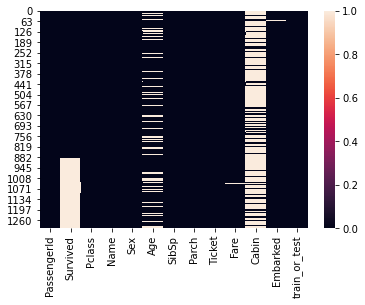

In [9]:
#Visualization to check for missing values
sns.heatmap(all.isnull())

Age, Cabin have significant rows with missing values,while Fare & Embarked have a few rows. Survived missing values from test data.

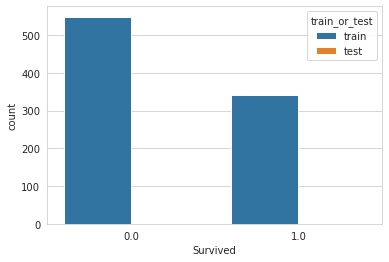

In [10]:
#Survived
sns.set_style('whitegrid')
sns.countplot('Survived',hue='train_or_test',data=all)

In [11]:
#Pclass
all['Pclass'].value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

In [12]:
groupby_df = all[all['train_or_test']=='train'].groupby(['Pclass', 'Survived']).agg({'Survived': 'count'})
groupby_pcts = groupby_df.groupby(level=0).apply(lambda x:round(100 * x / x.sum(),2))
groupby_df,groupby_pcts

(                 Survived
 Pclass Survived          
 1      0.0             80
        1.0            136
 2      0.0             97
        1.0             87
 3      0.0            372
        1.0            119,
                  Survived
 Pclass Survived          
 1      0.0          37.04
        1.0          62.96
 2      0.0          52.72
        1.0          47.28
 3      0.0          75.76
        1.0          24.24)

Clearly Pclass=1 has higher chance of survival ~63% vs Pclass=2(47%) and Pclass=3(24%)

In [13]:
#Name
all['Name'].value_counts()

Connolly, Miss. Kate                       2
Kelly, Mr. James                           2
Knight, Mr. Robert J                       1
Sincock, Miss. Maude                       1
Lurette, Miss. Elise                       1
                                          ..
Nankoff, Mr. Minko                         1
Danbom, Master. Gilbert Sigvard Emanuel    1
Radeff, Mr. Alexander                      1
Taussig, Mr. Emil                          1
Lahtinen, Rev. William                     1
Name: Name, Length: 1307, dtype: int64

In [14]:
sum(all['Name'].value_counts()>1)

2

In [15]:
all[(all['Name']=='Kelly, Mr. James') | (all['Name']=='Connolly, Miss. Kate')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_or_test
289,290,1.0,3,"Connolly, Miss. Kate",female,22.0,0,0,370373,7.7500,NaN,Q,train
696,697,0.0,3,"Kelly, Mr. James",male,44.0,0,0,363592,8.0500,NaN,S,train
891,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,test
897,898,NaN,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,test


In [16]:
#Sex
all['Sex'].value_counts()

male      843
female    466
Name: Sex, dtype: int64

In [17]:
groupby_df = all[all['train_or_test']=='train'].groupby(['Sex', 'Survived']).agg({'Survived': 'count'})
groupby_pcts = groupby_df.groupby(level=0).apply(lambda x:round(100 * x / x.sum(),2))
groupby_df,groupby_pcts

(                 Survived
 Sex    Survived          
 female 0.0             81
        1.0            233
 male   0.0            468
        1.0            109,
                  Survived
 Sex    Survived          
 female 0.0          25.80
        1.0          74.20
 male   0.0          81.11
        1.0          18.89)

Female has higher chance of survival ~74% vs Male 19%

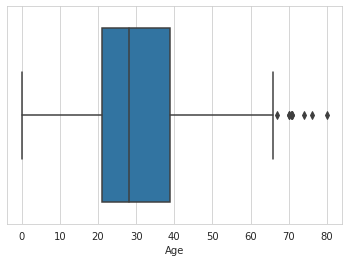

In [18]:
#Age
sns.boxplot(all['Age'])

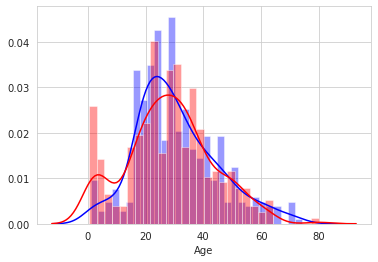

In [19]:
sns.distplot(all[all['Survived']==0]['Age'],bins=30,color='blue')
sns.distplot(all[all['Survived']==1]['Age'],bins=30,color='red')

Lower age has higher chance of survival and the ages are almost normally distributed. 

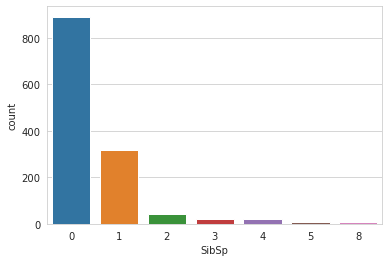

In [20]:
#SibSp
sns.countplot('SibSp',data=all)

In [21]:
groupby_df = all[all['train_or_test']=='train'].groupby(['SibSp', 'Survived']).agg({'Survived': 'count'})
groupby_pcts = groupby_df.groupby(level=0).apply(lambda x:round(100 * x / x.sum(),2))
groupby_df,groupby_pcts

(                Survived
 SibSp Survived          
 0     0.0            398
       1.0            210
 1     0.0             97
       1.0            112
 2     0.0             15
       1.0             13
 3     0.0             12
       1.0              4
 4     0.0             15
       1.0              3
 5     0.0              5
 8     0.0              7,
                 Survived
 SibSp Survived          
 0     0.0          65.46
       1.0          34.54
 1     0.0          46.41
       1.0          53.59
 2     0.0          53.57
       1.0          46.43
 3     0.0          75.00
       1.0          25.00
 4     0.0          83.33
       1.0          16.67
 5     0.0         100.00
 8     0.0         100.00)

Passengers with 1,2 Siblings/Spouses have a higher chance of Survival 

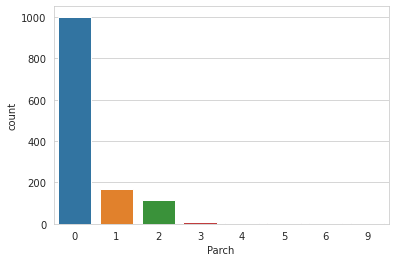

In [22]:
#Parch
sns.countplot('Parch',data=all)

In [23]:
groupby_df = all[all['train_or_test']=='train'].groupby(['Parch', 'Survived']).agg({'Survived': 'count'})
groupby_pcts = groupby_df.groupby(level=0).apply(lambda x:round(100 * x / x.sum(),2))
groupby_df,groupby_pcts

(                Survived
 Parch Survived          
 0     0.0            445
       1.0            233
 1     0.0             53
       1.0             65
 2     0.0             40
       1.0             40
 3     0.0              2
       1.0              3
 4     0.0              4
 5     0.0              4
       1.0              1
 6     0.0              1,
                 Survived
 Parch Survived          
 0     0.0          65.63
       1.0          34.37
 1     0.0          44.92
       1.0          55.08
 2     0.0          50.00
       1.0          50.00
 3     0.0          40.00
       1.0          60.00
 4     0.0         100.00
 5     0.0          80.00
       1.0          20.00
 6     0.0         100.00)

1-3 Parents/Children have higher chance of Survival

In [24]:
#Ticket
all['Ticket'].value_counts()

CA. 2343        11
1601             8
CA 2144          8
347082           7
S.O.C. 14879     7
                ..
234604           1
349222           1
2647             1
349249           1
349230           1
Name: Ticket, Length: 929, dtype: int64

In [25]:
sum(all['Ticket'].value_counts()>1)

216

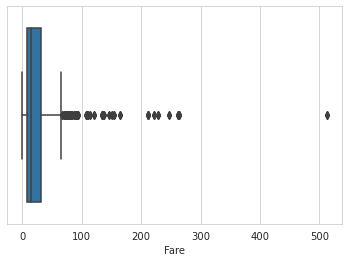

In [26]:
#Fare
sns.boxplot(all['Fare'])

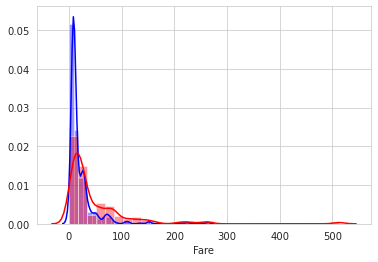

In [27]:
sns.distplot(all[all['Survived']==0]['Fare'],bins=30,color='blue')
sns.distplot(all[all['Survived']==1]['Fare'],bins=30,color='red')

We see passengers with higher Fare have a higher chance of survival

In [28]:
#Cabin
all['Cabin'].value_counts()

C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
C78                4
F4                 4
                  ..
D11                1
C70                1
A5                 1
C118               1
E63                1
Name: Cabin, Length: 186, dtype: int64

In [29]:
sum(all['Cabin'].value_counts()>1)

79

In [30]:
all['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [31]:
groupby_df = all[all['train_or_test']=='train'].groupby(['Embarked', 'Survived']).agg({'Survived': 'count'})
groupby_pcts = groupby_df.groupby(level=0).apply(lambda x:round(100 * x / x.sum(),2))
groupby_df,groupby_pcts

(                   Survived
 Embarked Survived          
 C        0.0             75
          1.0             93
 Q        0.0             47
          1.0             30
 S        0.0            427
          1.0            217,
                    Survived
 Embarked Survived          
 C        0.0          44.64
          1.0          55.36
 Q        0.0          61.04
          1.0          38.96
 S        0.0          66.30
          1.0          33.70)

Embarked C has a higher chance of survival

#### Bivariate Analysis

In [32]:
all.dtypes

PassengerId        int64
Survived         float64
Pclass             int64
Name              object
Sex               object
Age              float64
SibSp              int64
Parch              int64
Ticket            object
Fare             float64
Cabin             object
Embarked          object
train_or_test     object
dtype: object

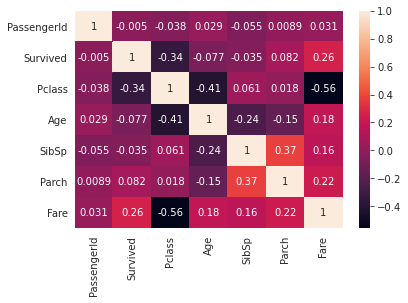

In [33]:
sns.heatmap(all.corr(),annot=True)

##### Continuous & Continuous

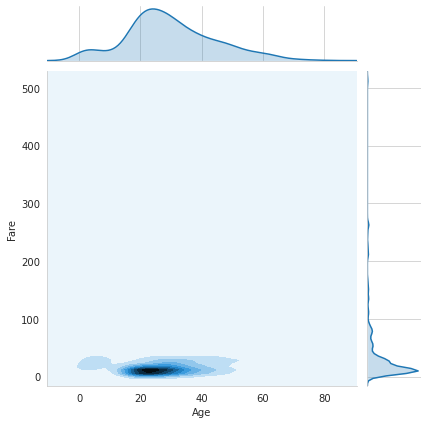

In [34]:
sns.jointplot(x='Age',y='Fare',data=all,kind='kde')

In [35]:
#Correlation
all.corr()['Fare']['Age']

0.1787398559996414

##### Categorical & Categorical

In [36]:
from scipy.stats import chi2

In [37]:
def chi_test(df,col1,col2):
    
    #Contingency Table
    contingency_table=pd.crosstab(df[col1],df[col2])
    #print('contingency_table :-\n',contingency_table)

    #Observed Values
    Observed_Values = contingency_table.values 
    #print("\nObserved Values :-\n",Observed_Values)

    #Expected Values
    import scipy.stats
    b=scipy.stats.chi2_contingency(contingency_table)
    Expected_Values = b[3]
    #print("\nExpected Values :-\n",Expected_Values)

    #Degree of Freedom
    no_of_rows=len(contingency_table.iloc[0:2,0])
    no_of_columns=len(contingency_table.iloc[0,0:2])
    df=(no_of_rows-1)*(no_of_columns-1)
    #print("\nDegree of Freedom:-",df)

    #Significance Level 5%
    alpha=0.05
    #print('\nSignificance level: ',alpha)

    #chi-square statistic - χ2
    chi_square=sum([(o-e)**2./e for o,e in zip(Observed_Values,Expected_Values)])
    chi_square_statistic=chi_square[0]+chi_square[1]
    #print("\nchi-square statistic:-",chi_square_statistic)

    #critical_value
    critical_value=chi2.ppf(q=1-alpha,df=df)
    #print('\ncritical_value:',critical_value)

    #p-value
    p_value=1-chi2.cdf(x=chi_square_statistic,df=df)
    #print('\np-value:',p_value)

    #compare chi_square_statistic with critical_value and p-value which is the probability of getting chi-square>0.09 (chi_square_statistic)
    if chi_square_statistic>=critical_value:
        print("\nchi_square_statistic & critical_value - significant result, reject null hypothesis (H0), dependent.")
    else:
        print("\nchi_square_statistic & critical_value - not significant result, fail to reject null hypothesis (H0).")

    if p_value<=alpha:
        print("\np_value & alpha - significant result, reject null hypothesis (H0), dependent.")
    else:
        print("\np_value & alpha - not significant result, fail to reject null hypothesis (H0), independent.")

In [38]:
#Sex & Pclass
chi_test(all,'Sex','Pclass')


chi_square_statistic & critical_value - significant result, reject null hypothesis (H0), dependent.

p_value & alpha - significant result, reject null hypothesis (H0), dependent.


In [39]:
#Sex & Parch
chi_test(all,'Sex','Parch')


chi_square_statistic & critical_value - significant result, reject null hypothesis (H0), dependent.

p_value & alpha - significant result, reject null hypothesis (H0), dependent.


In [40]:
#Sex & SibSp
chi_test(all,'Sex','SibSp')


chi_square_statistic & critical_value - significant result, reject null hypothesis (H0), dependent.

p_value & alpha - significant result, reject null hypothesis (H0), dependent.


In [41]:
#Sex & Embarked
chi_test(all,'Sex','Embarked')


chi_square_statistic & critical_value - significant result, reject null hypothesis (H0), dependent.

p_value & alpha - significant result, reject null hypothesis (H0), dependent.


In [42]:
#Pclass & SibSp
chi_test(all,'Pclass','SibSp')


chi_square_statistic & critical_value - significant result, reject null hypothesis (H0), dependent.

p_value & alpha - significant result, reject null hypothesis (H0), dependent.


In [43]:
#Pclass & Parch
chi_test(all,'Pclass','Parch')


chi_square_statistic & critical_value - significant result, reject null hypothesis (H0), dependent.

p_value & alpha - significant result, reject null hypothesis (H0), dependent.


In [44]:
#Pclass & Embarked
chi_test(all,'Pclass','Embarked')


chi_square_statistic & critical_value - significant result, reject null hypothesis (H0), dependent.

p_value & alpha - significant result, reject null hypothesis (H0), dependent.


In [45]:
#SibSp & Parch
chi_test(all,'SibSp','Parch')


chi_square_statistic & critical_value - significant result, reject null hypothesis (H0), dependent.

p_value & alpha - significant result, reject null hypothesis (H0), dependent.


In [46]:
#SibSp & Embarked
chi_test(all,'SibSp','Embarked')


chi_square_statistic & critical_value - significant result, reject null hypothesis (H0), dependent.

p_value & alpha - significant result, reject null hypothesis (H0), dependent.


In [47]:
#Parch & Embarked
chi_test(all,'Parch','Embarked')


chi_square_statistic & critical_value - significant result, reject null hypothesis (H0), dependent.

p_value & alpha - significant result, reject null hypothesis (H0), dependent.


All the categorical variables seem to be dependent on each other

##### Categorical & Continuous 

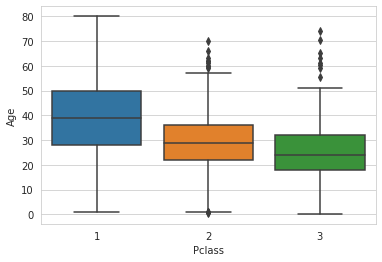

In [48]:
#Pclass & Age
sns.boxplot(x='Pclass',y='Age',data=all)

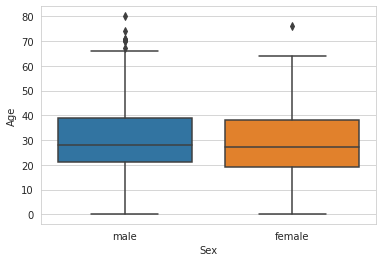

In [49]:
#Sex & Age
sns.boxplot(x='Sex',y='Age',data=all)

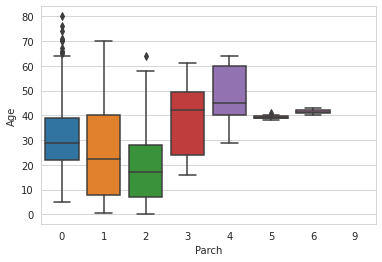

In [50]:
#Parch & Age
sns.boxplot(x='Parch',y='Age',data=all)

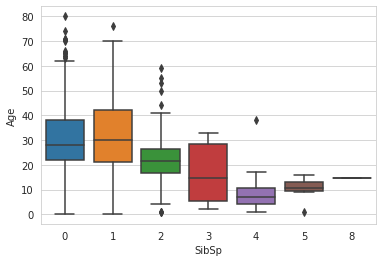

In [51]:
#SibSp & Age
sns.boxplot(x='SibSp',y='Age',data=all)

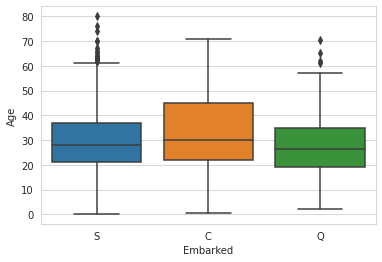

In [52]:
#Embarked & Age
sns.boxplot(x='Embarked',y='Age',data=all)

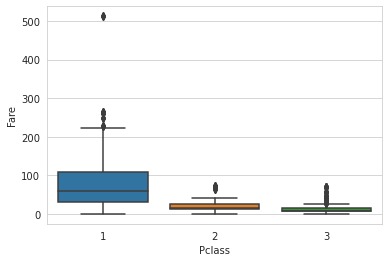

In [53]:
#Pclass & Fare
sns.boxplot(x='Pclass',y='Fare',data=all)

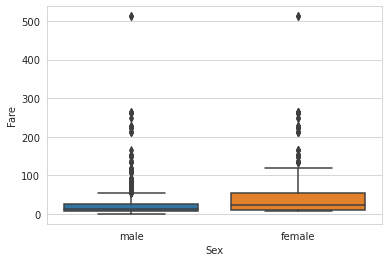

In [54]:
#Sex & Fare
sns.boxplot(x='Sex',y='Fare',data=all)

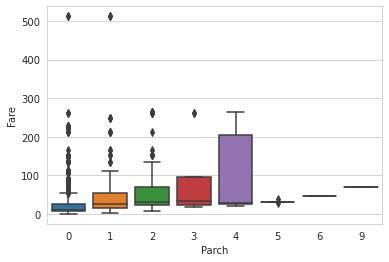

In [55]:
#Parch & Fare
sns.boxplot(x='Parch',y='Fare',data=all)

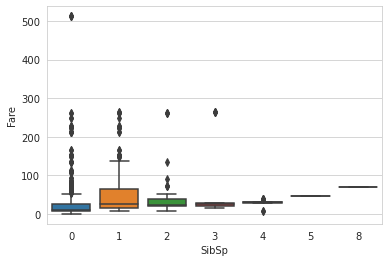

In [56]:
#SibSp & Fare
sns.boxplot(x='SibSp',y='Fare',data=all)

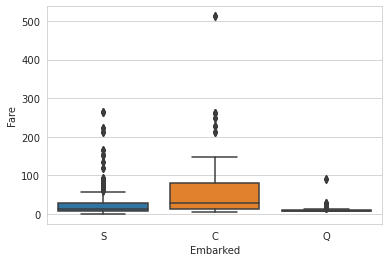

In [57]:
#Embarked & Fare
sns.boxplot(x='Embarked',y='Fare',data=all)

#### Missing Value Treatment

In [58]:
all.isnull().sum()

PassengerId         0
Survived          418
Pclass              0
Name                0
Sex                 0
Age               263
SibSp               0
Parch               0
Ticket              0
Fare                1
Cabin            1014
Embarked            2
train_or_test       0
dtype: int64

In [59]:
#Filling Embarked with most common value
all['Embarked']=all['Embarked'].fillna('S')

#Filling Fare with mean(Fare)
all['Fare']=all['Fare'].fillna(all['Fare'].mean())

In [60]:
#Imputing Age
index_NaN_age = list(all[all["Age"].isnull()]["Age"].index)

for i in index_NaN_age :
    age_med = all["Age"].median()
    age_pred = all[((all['SibSp'] == all.iloc[i]["SibSp"]) & (all['Parch'] == all.iloc[i]["Parch"]) & (all['Pclass'] == all.iloc[i]["Pclass"]))]["Age"].median()
    if not np.isnan(age_pred) :
        all['Age'].iloc[i] = age_pred
    else :
        all['Age'].iloc[i] = age_med

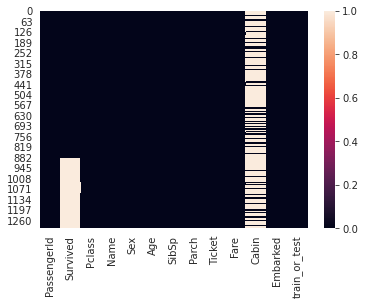

In [61]:
sns.heatmap(all.isnull())

#### Outlier Detection

In [62]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(all[all['train_or_test']=='train'],2,["Age","SibSp","Parch","Fare"])

In [63]:
all.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_or_test
438,439,0.0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.00,C23 C25 C27,S,train
587,588,1.0,1,"Frolicher-Stehli, Mr. Maxmillian",male,60.0,1,1,13567,79.20,B41,C,train
745,746,0.0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.00,B22,S,train
27,28,0.0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S,train
88,89,1.0,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S,train
159,160,0.0,3,"Sage, Master. Thomas Henry",male,14.5,8,2,CA. 2343,69.55,NaN,S,train
180,181,0.0,3,"Sage, Miss. Constance Gladys",female,14.5,8,2,CA. 2343,69.55,NaN,S,train
201,202,0.0,3,"Sage, Mr. Frederick",male,14.5,8,2,CA. 2343,69.55,NaN,S,train
324,325,0.0,3,"Sage, Mr. George John Jr",male,14.5,8,2,CA. 2343,69.55,NaN,S,train
341,342,1.0,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S,train


In [64]:
all = all.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

#### Feature Engineering

##### Pclass

In [65]:
all['Pclass'].value_counts() #No Feature Engineering

3    702
1    317
2    277
Name: Pclass, dtype: int64

##### Fare

In [66]:
all['Fare'].median() #Before Feature Engineering

14.4542

In [67]:
all['FareBand'] = pd.qcut(all['Fare'], 4)

In [68]:
all['FareBand'].value_counts()

(-0.001, 7.896]    337
(30.5, 512.329]    323
(7.896, 14.454]    320
(14.454, 30.5]     316
Name: FareBand, dtype: int64

In [69]:
all.loc[ all['Fare'] <= 7.9, 'Fare'] = 0
all.loc[(all['Fare'] > 7.9) & (all['Fare'] <= 14.4), 'Fare'] = 1
all.loc[(all['Fare'] > 14.4) & (all['Fare'] <= 30.5), 'Fare']   = 2
all.loc[ all['Fare'] > 30.5, 'Fare'] = 3

In [70]:
all['Fare'].value_counts()

0.0    337
2.0    326
3.0    323
1.0    310
Name: Fare, dtype: int64

Converted Fare into bands

##### Age

In [71]:
all['Age'].median() #Before Feature Engineering

26.0

In [72]:
all['AgeBand'] = pd.cut(all['Age'], 5)

In [73]:
all['AgeBand'].value_counts()

(16.136, 32.102]    724
(32.102, 48.068]    308
(0.0902, 16.136]    148
(48.068, 64.034]    104
(64.034, 80.0]       12
Name: AgeBand, dtype: int64

In [74]:
all.loc[ all['Age'] <= 16, 'Age'] = 0
all.loc[(all['Age'] > 16) & (all['Age'] <= 32), 'Age'] = 1
all.loc[(all['Age'] > 32) & (all['Age'] <= 48), 'Age'] = 2
all.loc[(all['Age'] > 48) & (all['Age'] <= 64), 'Age'] = 3
all.loc[ all['Age'] > 64, 'Age']=5

In [75]:
all['Age'].value_counts()

1.0    724
2.0    308
0.0    148
3.0    104
5.0     12
Name: Age, dtype: int64

Converted Age into bands

##### Name

In [76]:
split_one = all['Name'].str.split('.', n=1, expand = True)
all['First'] = split_one[0]
all['Last'] = split_one[1]
split_two = all['First'].str.split(',', n=1, expand = True)
all['Last Name'] = split_two[0]
all['Title'] = split_two[1]
split_three = all['Title'].str.split('', n=1, expand = True)

split_three


,0,1
0,,Mr
1,,Mrs
2,,Miss
3,,Mrs
4,,Mr
...,...,...
1291,,Mr
1292,,Dona
1293,,Mr
1294,,Mr


In [77]:
all['Title'].value_counts()

 Mr              751
 Miss            255
 Mrs             197
 Master           60
 Rev               8
 Dr                8
 Col               4
 Ms                2
 Major             2
 Mlle              2
 Sir               1
 Dona              1
 Jonkheer          1
 the Countess      1
 Lady              1
 Mme               1
 Don               1
Name: Title, dtype: int64

In [78]:
all.drop(['First','Last','Name','Last Name'],axis = 1,inplace = True)

In [79]:
all.replace(to_replace = [ ' Don', ' Rev', ' Dr', ' Mme',
        ' Major', ' Sir', ' Col', ' Capt',' Jonkheer'], value = ' Honorary(M)', inplace = True)

all.replace(to_replace = [ ' Ms', ' Lady', ' Mlle',' the Countess', ' Dona'], value = ' Honorary(F)', inplace = True)

all['Title'].value_counts()

 Mr             751
 Miss           255
 Mrs            197
 Master          60
 Honorary(M)     26
 Honorary(F)      7
Name: Title, dtype: int64

In [80]:
all = pd.get_dummies(all, columns = ['Title'],prefix='Title_',drop_first=True)
all.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_or_test,FareBand,AgeBand,Title__ Honorary(M),Title__ Master,Title__ Miss,Title__ Mr,Title__ Mrs
0,1,0.0,3,male,1.0,1,0,A/5 21171,0.0,NaN,S,train,"(-0.001, 7.896]","(16.136, 32.102]",0,0,0,1,0
1,2,1.0,1,female,2.0,1,0,PC 17599,3.0,C85,C,train,"(30.5, 512.329]","(32.102, 48.068]",0,0,0,0,1
2,3,1.0,3,female,1.0,0,0,STON/O2. 3101282,1.0,NaN,S,train,"(7.896, 14.454]","(16.136, 32.102]",0,0,1,0,0
3,4,1.0,1,female,2.0,1,0,113803,3.0,C123,S,train,"(30.5, 512.329]","(32.102, 48.068]",0,0,0,0,1
4,5,0.0,3,male,2.0,0,0,373450,1.0,NaN,S,train,"(7.896, 14.454]","(32.102, 48.068]",0,0,0,1,0


##### SibSp + Parch = Family Size

In [81]:
all['Family'] = all['SibSp'] + all['Parch'] + 1

In [82]:
all['Single'] = all['Family'].map(lambda s: 1 if s == 1 else 0)
all['SmallF'] = all['Family'].map(lambda s: 1 if  s == 2  else 0)
all['MedF'] = all['Family'].map(lambda s: 1 if 3 <= s <= 4 else 0)
all['LargeF'] = all['Family'].map(lambda s: 1 if s >= 5 else 0)
all.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Title__ Honorary(M),Title__ Master,Title__ Miss,Title__ Mr,Title__ Mrs,Family,Single,SmallF,MedF,LargeF
0,1,0.0,3,male,1.0,1,0,A/5 21171,0.0,NaN,...,0,0,0,1,0,2,0,1,0,0
1,2,1.0,1,female,2.0,1,0,PC 17599,3.0,C85,...,0,0,0,0,1,2,0,1,0,0
2,3,1.0,3,female,1.0,0,0,STON/O2. 3101282,1.0,NaN,...,0,0,1,0,0,1,1,0,0,0
3,4,1.0,1,female,2.0,1,0,113803,3.0,C123,...,0,0,0,0,1,2,0,1,0,0
4,5,0.0,3,male,2.0,0,0,373450,1.0,NaN,...,0,0,0,1,0,1,1,0,0,0


##### Embarked

In [83]:
all = pd.get_dummies(all, columns = ['Embarked'], prefix='Embarked_from_',drop_first=True)
all.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Title__ Miss,Title__ Mr,Title__ Mrs,Family,Single,SmallF,MedF,LargeF,Embarked_from__Q,Embarked_from__S
0,1,0.0,3,male,1.0,1,0,A/5 21171,0.0,NaN,...,0,1,0,2,0,1,0,0,0,1
1,2,1.0,1,female,2.0,1,0,PC 17599,3.0,C85,...,0,0,1,2,0,1,0,0,0,0
2,3,1.0,3,female,1.0,0,0,STON/O2. 3101282,1.0,NaN,...,1,0,0,1,1,0,0,0,0,1
3,4,1.0,1,female,2.0,1,0,113803,3.0,C123,...,0,0,1,2,0,1,0,0,0,1
4,5,0.0,3,male,2.0,0,0,373450,1.0,NaN,...,0,1,0,1,1,0,0,0,0,1


##### Cabin

In [84]:
all.drop('Cabin',axis=1,inplace=True)

##### Ticket

In [85]:
all['Ticket'].unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '330959', '349216', 'PC 17601', 'PC 17569',
       '335677', 'C.A. 24579', 'PC 17604', '113789', '2677', 'A./5. 2152',
       '345764', '2651', '7546', '11668', '349253', 'SC/Paris 2123',
       '330958', 'S.C./A.4. 23567', '370371', '14311', '2662', '349237',
       '3101295', 'A/4. 39886', 'PC 17572', '2926', '113509', '19947',
       'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144', '2669', '113572',
       '36973', '347088', 'PC 17605', '2661', 'C.A. 29395', 'S.P. 3464',
       '3101281', '315151', 'C.A. 33111', 'S.O.C. 14879', '2680', '1601',
       '348123', '349208', '374746', '248738', '364516', '345767',
       '345779', '330932', '113059', 'SO/C 14885', '3101278',
       'W./

In [86]:
all['Ticket'].value_counts()

1601            8
CA 2144         8
S.O.C. 14879    7
347082          7
3101295         7
               ..
234604          1
349222          1
2647            1
349249          1
349230          1
Name: Ticket, Length: 929, dtype: int64

In [87]:
all['Ticket'] = all['Ticket'].astype(str)
all['Ticket_length'] = all['Ticket'].apply(len)
all['Ticket_length'].astype(int)
all['Ticket_length'].unique()

array([ 9,  8, 16,  6,  5,  7,  4, 10, 13, 15, 12, 11, 17, 18,  3])

In [88]:
all['Ticket_length'] = np.where(((all['Ticket_length'] == 3) | (all['Ticket_length'] == 4) | (all['Ticket_length'] == 5)),4,all['Ticket_length'])

all['Ticket_length'] = np.where(((all['Ticket_length'] == 6)),5,all['Ticket_length'])

all['Ticket_length'] = np.where(((all['Ticket_length'] == 7) | (all['Ticket_length'] == 8) | (all['Ticket_length'] == 9) | (all['Ticket_length'] == 10) | (all['Ticket_length'] == 13)
                                 | (all['Ticket_length'] == 17)| (all['Ticket_length'] == 16)| (all['Ticket_length'] == 13)| (all['Ticket_length'] == 12) | (all['Ticket_length'] == 15)
                                 | (all['Ticket_length'] == 11)| (all['Ticket_length'] == 18)),12,all['Ticket_length'])



In [89]:
all['Ticket_length'].unique()

array([12,  5,  4])

In [90]:
all['Ticket_length'] = all['Ticket_length'].astype(str)

all['Ticket_length'] = np.where(((all['Ticket_length'] == '4')),'Below 6',all['Ticket_length'])
all['Ticket_length'] = np.where(((all['Ticket_length'] == '5')),'At 6',all['Ticket_length'])
all['Ticket_length'] = np.where(((all['Ticket_length'] == '12')),'Above 6',all['Ticket_length'])

In [91]:
all['Ticket_length'].unique()

array(['Above 6', 'At 6', 'Below 6'], dtype=object)

In [92]:
all = pd.get_dummies(all, columns=['Ticket_length'], prefix = 'Ticket_Length_',drop_first=True)
all.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,train_or_test,...,Title__ Mrs,Family,Single,SmallF,MedF,LargeF,Embarked_from__Q,Embarked_from__S,Ticket_Length__At 6,Ticket_Length__Below 6
0,1,0.0,3,male,1.0,1,0,A/5 21171,0.0,train,...,0,2,0,1,0,0,0,1,0,0
1,2,1.0,1,female,2.0,1,0,PC 17599,3.0,train,...,1,2,0,1,0,0,0,0,0,0
2,3,1.0,3,female,1.0,0,0,STON/O2. 3101282,1.0,train,...,0,1,1,0,0,0,0,1,0,0
3,4,1.0,1,female,2.0,1,0,113803,3.0,train,...,1,2,0,1,0,0,0,1,1,0
4,5,0.0,3,male,2.0,0,0,373450,1.0,train,...,0,1,1,0,0,0,0,1,1,0


In [93]:
all.drop(['Ticket'],axis = 1, inplace = True)

##### Sex

In [94]:
all = pd.get_dummies(all, columns = ['Sex'],prefix='Gender_',drop_first=True)
all.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_or_test,FareBand,AgeBand,...,Family,Single,SmallF,MedF,LargeF,Embarked_from__Q,Embarked_from__S,Ticket_Length__At 6,Ticket_Length__Below 6,Gender__male
0,1,0.0,3,1.0,1,0,0.0,train,"(-0.001, 7.896]","(16.136, 32.102]",...,2,0,1,0,0,0,1,0,0,1
1,2,1.0,1,2.0,1,0,3.0,train,"(30.5, 512.329]","(32.102, 48.068]",...,2,0,1,0,0,0,0,0,0,0
2,3,1.0,3,1.0,0,0,1.0,train,"(7.896, 14.454]","(16.136, 32.102]",...,1,1,0,0,0,0,1,0,0,0
3,4,1.0,1,2.0,1,0,3.0,train,"(30.5, 512.329]","(32.102, 48.068]",...,2,0,1,0,0,0,1,1,0,0
4,5,0.0,3,2.0,0,0,1.0,train,"(7.896, 14.454]","(32.102, 48.068]",...,1,1,0,0,0,0,1,1,0,1


In [95]:
all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   PassengerId             1296 non-null   int64   
 1   Survived                878 non-null    float64 
 2   Pclass                  1296 non-null   int64   
 3   Age                     1296 non-null   float64 
 4   SibSp                   1296 non-null   int64   
 5   Parch                   1296 non-null   int64   
 6   Fare                    1296 non-null   float64 
 7   train_or_test           1296 non-null   object  
 8   FareBand                1296 non-null   category
 9   AgeBand                 1296 non-null   category
 10  Title__ Honorary(M)     1296 non-null   uint8   
 11  Title__ Master          1296 non-null   uint8   
 12  Title__ Miss            1296 non-null   uint8   
 13  Title__ Mr              1296 non-null   uint8   
 14  Title__ Mrs             

In [96]:
all.drop(['SibSp','Parch','Family','FareBand','AgeBand'],axis = 1,inplace = True)

In [97]:
all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PassengerId             1296 non-null   int64  
 1   Survived                878 non-null    float64
 2   Pclass                  1296 non-null   int64  
 3   Age                     1296 non-null   float64
 4   Fare                    1296 non-null   float64
 5   train_or_test           1296 non-null   object 
 6   Title__ Honorary(M)     1296 non-null   uint8  
 7   Title__ Master          1296 non-null   uint8  
 8   Title__ Miss            1296 non-null   uint8  
 9   Title__ Mr              1296 non-null   uint8  
 10  Title__ Mrs             1296 non-null   uint8  
 11  Single                  1296 non-null   int64  
 12  SmallF                  1296 non-null   int64  
 13  MedF                    1296 non-null   int64  
 14  LargeF                  1296 non-null   

In [98]:
train_data,test_data=all[all['train_or_test']=='train'],all[all['train_or_test']=='test']
train_data.drop('train_or_test',axis=1,inplace=True)
test_data.drop('train_or_test',axis=1,inplace=True)

In [99]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878 entries, 0 to 877
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PassengerId             878 non-null    int64  
 1   Survived                878 non-null    float64
 2   Pclass                  878 non-null    int64  
 3   Age                     878 non-null    float64
 4   Fare                    878 non-null    float64
 5   Title__ Honorary(M)     878 non-null    uint8  
 6   Title__ Master          878 non-null    uint8  
 7   Title__ Miss            878 non-null    uint8  
 8   Title__ Mr              878 non-null    uint8  
 9   Title__ Mrs             878 non-null    uint8  
 10  Single                  878 non-null    int64  
 11  SmallF                  878 non-null    int64  
 12  MedF                    878 non-null    int64  
 13  LargeF                  878 non-null    int64  
 14  Embarked_from__Q        878 non-null    ui

In [100]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 878 to 1295
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PassengerId             418 non-null    int64  
 1   Survived                0 non-null      float64
 2   Pclass                  418 non-null    int64  
 3   Age                     418 non-null    float64
 4   Fare                    418 non-null    float64
 5   Title__ Honorary(M)     418 non-null    uint8  
 6   Title__ Master          418 non-null    uint8  
 7   Title__ Miss            418 non-null    uint8  
 8   Title__ Mr              418 non-null    uint8  
 9   Title__ Mrs             418 non-null    uint8  
 10  Single                  418 non-null    int64  
 11  SmallF                  418 non-null    int64  
 12  MedF                    418 non-null    int64  
 13  LargeF                  418 non-null    int64  
 14  Embarked_from__Q        418 non-null   

In [101]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,Fare,Title__ Honorary(M),Title__ Master,Title__ Miss,Title__ Mr,Title__ Mrs,Single,SmallF,MedF,LargeF,Embarked_from__Q,Embarked_from__S,Ticket_Length__At 6,Ticket_Length__Below 6,Gender__male
count,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000
mean,446.220957,0.386105,2.312073,1.322323,1.488610,0.023918,0.044419,0.201595,0.582005,0.142369,0.611617,0.183371,0.146925,0.058087,0.087699,0.722096,0.477221,0.260820,0.648064
std,256.811901,0.487133,0.832967,0.869988,1.116573,0.152881,0.206142,0.401420,0.493511,0.349627,0.487660,0.387191,0.354233,0.234040,0.283018,0.448221,0.499766,0.439332,0.477846
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,225.250000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,447.500000,0.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,667.750000,1.000000,3.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,891.000000,1.000000,3.000000,5.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Building Models

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [103]:
#train & test split
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['PassengerId','Survived'],axis=1), 
                                                    train_data['Survived'], test_size=0.30, 
                                                    random_state=101)

##### I compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.

    SVC
    Decision Tree
    AdaBoost
    Random Forest
    Extra Trees
    Gradient Boosting
    Multiple layer perceprton (neural network)
    KNN
    Logistic regression
    Linear Discriminant Analysis


In [104]:
#Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

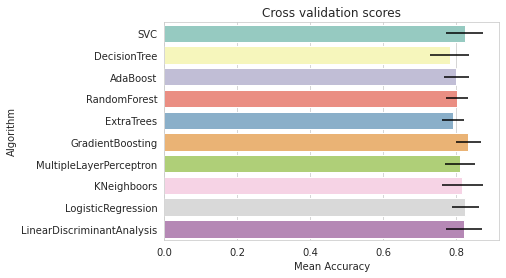

In [105]:
#Modeling step Test differents algorithms 
random_state = 101
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [106]:
cv_res.sort_values('CrossValMeans',ascending=False)

,CrossValMeans,CrossValerrors,Algorithm
5,0.833765,0.033799,GradientBoosting
8,0.825568,0.036441,LogisticRegression
0,0.823982,0.050809,SVC
9,0.822316,0.049075,LinearDiscriminantAnalysis
7,0.817451,0.056818,KNeighboors
6,0.810999,0.041591,MultipleLayerPerceptron
3,0.802856,0.029986,RandomForest
2,0.801163,0.033166,AdaBoost
4,0.791433,0.029545,ExtraTrees
1,0.783078,0.053665,DecisionTree


In [107]:
###META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

#Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_

#Best score
gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    6.4s finished


0.7994711792702273

In [108]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


##Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

#Best score
gsExtC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.4min finished


0.8272078265468007

In [109]:
#RFC Parameters tunning 
RFC = RandomForestClassifier()


##Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

#Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   29.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.5min finished


0.8353781068217874

In [110]:
#Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

#Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   19.3s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   37.0s finished


0.8141459545214171

In [111]:
#SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,y_train)

SVMC_best = gsSVMC.best_estimator_

#Best score
gsSVMC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   12.3s finished


0.8321258593336859

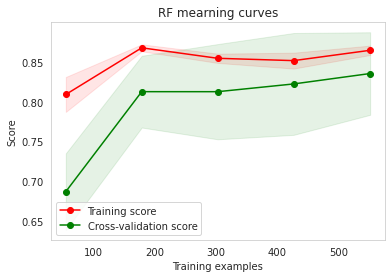

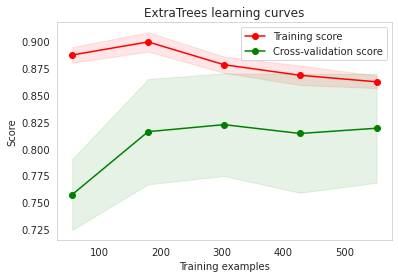

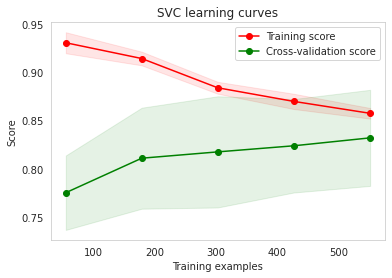

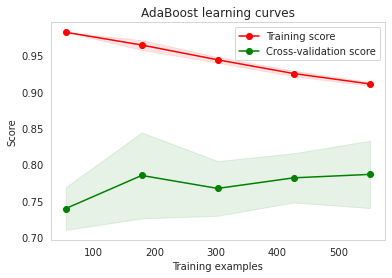

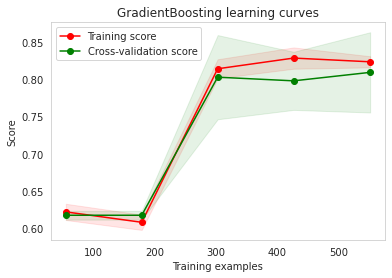

In [112]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,y_train,cv=kfold)

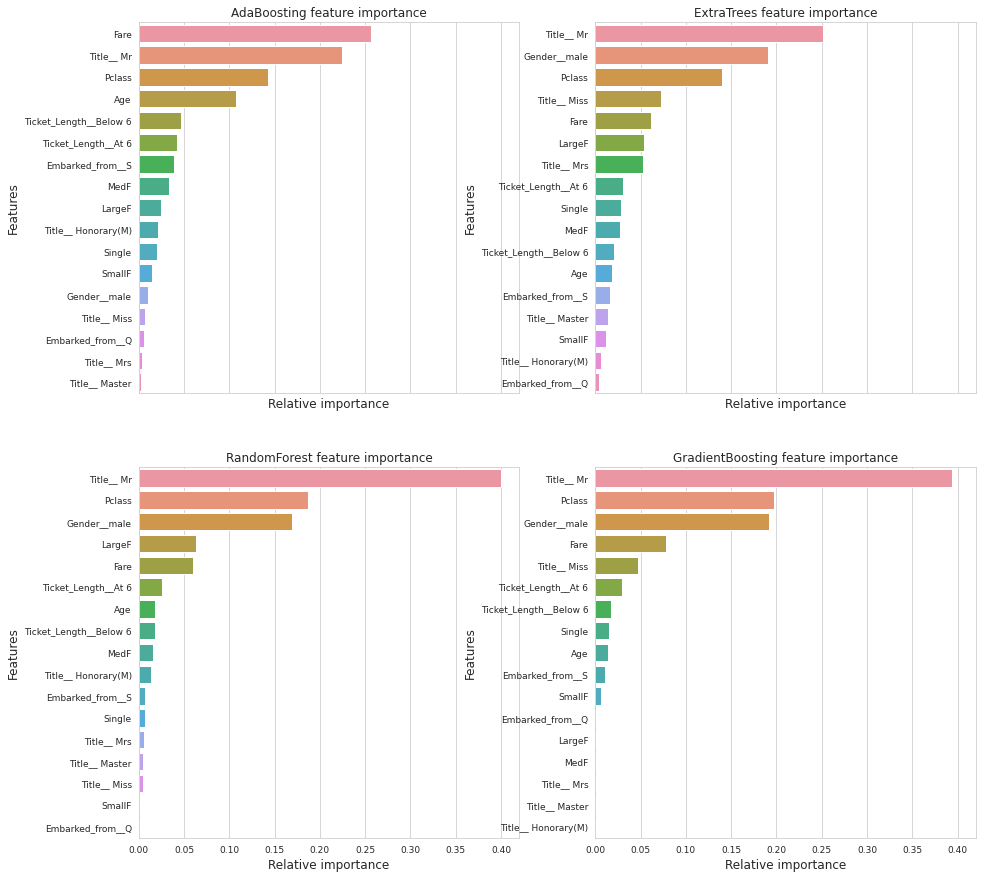

In [113]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

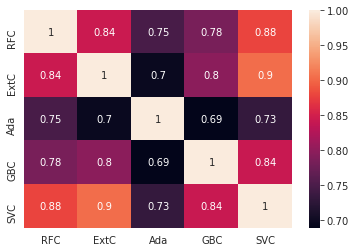

In [114]:
test_Survived_RFC = pd.Series(RFC_best.predict(test_data.drop(['PassengerId','Survived'],axis=1)), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test_data.drop(['PassengerId','Survived'],axis=1)), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test_data.drop(['PassengerId','Survived'],axis=1)), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test_data.drop(['PassengerId','Survived'],axis=1)), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test_data.drop(['PassengerId','Survived'],axis=1)), name="GBC")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [115]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best),('gbc',GBC_best)], voting='soft', n_jobs=4)
votingC = votingC.fit(X_train, y_train)

In [116]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': votingC.predict(test_data.drop(['PassengerId','Survived'],axis=1)).astype('int')})

output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [117]:
output

,PassengerId,Survived
878,892,0
879,893,0
880,894,0
881,895,0
882,896,0
...,...,...
1291,1305,0
1292,1306,1
1293,1307,0
1294,1308,0
